# Homework 2

### This is the solution of:
* Klas Henriksson klhe0017
* Joel Nilsson joni0295
* Daniel Dahlgren Lindström dali0125


The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom-style.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style 
#css_styling()

## Problem 1 (Finite Difference Method in 2D)

 **a)** Let $\Omega = (0,1)\times (0,1)$.
For the functions $u_k(x,y) = \sin(2 \pi k x) \sin(2 \pi k y)$ with frequency $k \in \mathbb{N}$,
compute analytically the right-hand side $f$ and boundary data $g$
such that $u_k$ satisfies the Poisson problem
\begin{align*}
- \Delta u_k  &= f \quad \text{in } \Omega,
\\
 u_k &= g \quad \text{on } \partial \Omega.
\end{align*}



**b)** Based on the code snippets below, implement a finite difference scheme to solve the problem given in a) for $k = 2$ numerically. For the computational grid, assume equally spaced subdivisions in $x$ and $y$ direction, starting with $N=8$ subintervals in each spatial direction. For $N = 8, 16, 32, 64$, compute and plot the finite difference solution $U$.

# Answers

## a)
We have
$$
- \Delta u_k = - \nabla \cdot \nabla u_k = - \nabla \cdot 2\pi k
\begin{bmatrix}
\sin(2\pi k y) \cos (2 \pi k x) \\
\sin(2 \pi k x) \cos (2 \pi k y) \\
\end{bmatrix}
= 8\pi^2 k^2 \sin (2 \pi k y) \sin (2 \pi k x) = f
$$
on $\Omega$.

Furthermore, we can divide the boundry $ \partial \Omega $ into four parts: $(x,y) = (x,0), (0,y), (x,1), (1,y)$.

From the first and second boundry we have
$$ u_k(x,0) = u_k(0,y) = 0 $$

The boundry $(x,y) = (x,1)$ have the expression
$$ u_k(x,1) = \sin (2 \pi k x) \sin (2 \pi k y) = 0 $$
as $k \in \mathbb{N}$. Similarly,
$$ u_k(1,y) = \sin (2 \pi k) \sin (2 \pi k x) = 0 $$
and so we have that the function vanishes at the boundry, and that $g = 0$ on $\partial \Omega$.

## b)
See code below.

### Code Snippets

As in Lab 1, places marked with $\ldots$ need you attention and must be filled with proper code.

We start with importing the necessary scientific libraries and define name aliases for them.

In [1]:
# Array and stuff 
import numpy as np
# Linear algebra solvers from scipy
import scipy.linalg as la
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt
# We also need access to the colormaps for 3D plotting
from matplotlib import cm
# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

Next, we define a surface plotting function.

In [3]:
def plot2D(X, Y, Z, title=""):
    # Define a new figure with given size 
    fig = plt.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z,             
                           rstride=1, cstride=1, # Sampling rates for the x and y input data
                           cmap=cm.viridis)      # Use the new fancy colormap viridis
    # Set initial view angle
    ax.view_init(30, 225)
    
    # Set labels and show figure
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(title)
    plt.show()

Now the real fun begins. We will implement our FDM in a function which takes the number of subintervals in each spatial direction $N$ and the frequency $k$ as arguments. We include a description of the function (a so-called "docstring") at the beginning of the function. To get a feeling for the various data structure we are going to use, it might be helpful to print out a few of them and to look them up in the numpy/scipy documentation while you implementing the scheme!

In addition to the inbuilt documentation in the Spyder IDE, you can also look up things easily by scanning through the method/class index at
https://docs.scipy.org/doc/numpy/genindex.html

In [31]:
def fdm_poisson_2d_dense(N, k):
    '''A simple finite difference solver in 2d using a full matrix representation.'''

    # 1) Compute right hand side     
    
    # To define the grid we could use "linspace" as in Lab 1 to define subdivisions for the $x$ and $y$ axes.
    # But to make plotting easy and to vectorize the evaluation of the right-hand side $f$,  
    # we define x and y coordinates for the grid using a "sparse grid" representation using the function 'ogrid'.
   
    x,y = np.ogrid[0:1:(N+1)*1j, 0:1:(N+1)*1j]
    # Here, 1j is not interpreted as the imaginary unit, rather "(N+1)*1j" forces to include the end points
    # Print x and y to see how they look like!
    
    # Evaluate f on the grid. 
    F_grid = 8 * np.pi**2 * k**2 * np.sin(2 * np.pi * k * x)*np.sin(2 * np.pi * k * y)
    
    # You can print F_grid to verify that you got a 2 dimensional array
    # print(F_grid)
    
    # You can also plot F_grid now if you want :)
    # plot2D(x, y, F_grid, "f")
    
    # Now we define our rhs by flattening out F, making it a 1 dimensional array of length (N+1)*(N+1). 
    F = F_grid.ravel()  
    
    # 2) Create Matrix entries for unknowns associated with inner grid points. 
    
    # To translate the grid based double index into a proper numbering, we define a 
    # small mapping function, assuming a row-wise numbering. 
    # Drawing a picture of the grid and numbering the grid points in a row wise manner
    # helps to understand this mapping!
    def m(i,j):
        return i + j * (N+1)

    # Total number of unknowns is M = (N+1)*(N+1)
    M = (N+1)**2
    
    # Allocate a (full!) MxM matrix filled with zeros
    A = np.zeros((M,M))
    
    # Meshsize h
    h = 1/N
    hh = h*h
    
    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(1,N):      # i is the row number for the grid point
        for j in range(1,N):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = m(i,j)       
            A[ri,m(i,j)] = 4/hh # U_ij
            A[ri,m(i-1,j)] = -1/hh   # U_{i-1,j}
            A[ri,m(i+1, j)] = -1/hh    # U_{i+1,j}
            A[ri,m(i,j-1)] = -1/hh    # U_{i,j-1}
            A[ri,m(i,j+1)] = -1/hh    # U_{i,j+1}
    
    # 3) Incorporate boundary conditions
    # Boundary condition 
    for i in [0, N]:
        for j in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1
            F[ri] = 0
    
    # Boundary condition 
    for j in [0, N]:
        for i in range(1,N):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1 
            F[ri] = 0     
    
    
    # 4) Solve linear systems
    # Solve linear algebra system 
    U = la.solve(A,F)
    
    # Reshape the flat solution vector U to make it a grid function
    U_grid = U.reshape((N+1,N+1))
    U_anal = np.sin(2 * np.pi * k * x)*np.sin(2*np.pi*k*y)
    
    # Return solution and x and y grid points for easy plotting
    return (x,y,U_grid, U_anal)

**c**) Compute the experimental order of convergence (EOC)
for $N = 16, 32, 64$ using $\max_{i} |U-u|$ as error measure. Summarize your results in a table. 
What convergence rate do you get? If you don't get an EOC very close to $2$, find the bugs in your code :)

**d**) Test how large you can chose the resolution $N$ until either the problem takes too long (say 5 minutes) to compute or uses too much memory. Explain, what happens. Why does the problem
scale so badly with respect to $N$?

# Answers

## c)
See table below! We got an EOC very close to 2.

## d)
We saw that for N = 256 our program froze and could not compute the solution. The problem scales very poorly. We can understand this by realizing that as we have (N+1)^2 unknowns, we get a very large (N+1)^2x(N+1)^2 matrix. If we double N, the matrix will have 16 times more elements. This quickly becomes a very large matrix, which consumes a lot of memory and also becomes much more time consuming to solve.

In [5]:
Ns = [8,16,32,64]
k = 2
errors = []
for N in Ns:
    (x,y,U_grid, U_analytic) = fdm_poisson_2d_dense(N, k)
    errors.append(np.max(np.abs(U_grid - U_analytic)))
    #plot2D(x,y,U_grid, f"U, N={N} k={k}")

In [23]:
    #do error stuff
    eocs = []
    for i in range(0,len(errors)-1):
        eoc = np.log(errors[i]/errors[i+1])/np.log(2)
        eocs.append(eoc)
    #eocs.append(np.nan)

    data = {"Error":errors[:len(errors)-1], "EOC":eocs}
    df = pd.DataFrame(data, index=Ns[1:len(Ns)])
    df = df[["Error", "EOC"]]
    df.index.name="N"
    df

,Error,EOC
N,,
16,0.233701,2.139800
32,0.053029,2.033754
64,0.012951,2.008367


**e**) Based on your implementation from, we now implement a finite difference using *sparse* matrices. Knowing the structure and entries of the matrix a priori, the most efficient 
realization would be based on (block) tridiagonal sparse matrices. 
But anticipating the forthcoming task of implementing schemes based on the finite element method, we will take a middle ground and simply switch to a flexible sparse matrix format which allows
for minimal adjustments of you previous solver implementation.
To this end you have incorporate the following code snippets into your code.

# Answers

## e)
See code below for implementation.

### Code Snippets

Get access to sparse matrices and sparse solvers.

In [2]:
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve

Use a sparse matrix format for $A$, see https://docs.scipy.org/doc/scipy-0.19.1/reference/sparse.html
for the many formats which are available. Here we use "dictionary of keys" based representation which
is an empty matrix to begin with and which can easily filled with non-zero values at the appropriate
places.

In [ ]:
A = sp.dok_matrix((M, M))

After creating the matrix we have to convert it to a different format, the so-called
"Compressed Sparse Row matrix" representation, which is much more efficient when solving the system $A U = F$ with a sparse solver.

In [ ]:
# Now convert A to format which is more efficient for solving
A_csr = A.tocsr() 
U = spsolve(A_csr, F)

In [30]:
def fdm_poisson_2d_sparse(N, k):
    '''A simple finite difference solver in 2d using a full matrix representation.'''

    # 1) Compute right hand side     
    
    # To define the grid we could use "linspace" as in Lab 1 to define subdivisions for the $x$ and $y$ axes.
    # But to make plotting easy and to vectorize the evaluation of the right-hand side $f$,  
    # we define x and y coordinates for the grid using a "sparse grid" representation using the function 'ogrid'.
   
    x,y = np.ogrid[0:1:(N+1)*1j, 0:1:(N+1)*1j]
    # Here, 1j is not interpreted as the imaginary unit, rather "(N+1)*1j" forces to include the end points
    # Print x and y to see how they look like!
    
    # Evaluate f on the grid. 
    F_grid = 8 * np.pi**2 * k**2 * np.sin(2 * np.pi * k * x)*np.sin(2 * np.pi * k * y)
    
    # You can print F_grid to verify that you got a 2 dimensional array
    # print(F_grid)
    
    # You can also plot F_grid now if you want :)
    # plot2D(x, y, F_grid, "f")
    
    # Now we define our rhs by flattening out F, making it a 1 dimensional array of length (N+1)*(N+1). 
    F = F_grid.ravel()  
    
    # 2) Create Matrix entries for unknowns associated with inner grid points. 
    
    # To translate the grid based double index into a proper numbering, we define a 
    # small mapping function, assuming a row-wise numbering. 
    # Drawing a picture of the grid and numbering the grid points in a row wise manner
    # helps to understand this mapping!
    def m(i,j):
        return i + j * (N+1)

    # Total number of unknowns is M = (N+1)*(N+1)
    M = (N+1)**2
    
    # Allocate a (full!) MxM matrix filled with zeros
    A = sp.dok_matrix((M,M))
    
    # Meshsize h
    h = 1/N
    hh = h*h
    
    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(1,N):      # i is the row number for the grid point
        for j in range(1,N):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = m(i,j)       
            A[ri,m(i,j)] = 4/hh # U_ij
            A[ri,m(i-1,j)] = -1/hh   # U_{i-1,j}
            A[ri,m(i+1, j)] = -1/hh    # U_{i+1,j}
            A[ri,m(i,j-1)] = -1/hh    # U_{i,j-1}
            A[ri,m(i,j+1)] = -1/hh    # U_{i,j+1}
    
    # 3) Incorporate boundary conditions
    # Boundary condition 
    for i in [0, N]:
        for j in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1
            F[ri] = 0
    
    # Boundary condition 
    for j in [0, N]:
        for i in range(1,N):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1 
            F[ri] = 0     
    
    
    # 4) Solve linear systems
    # Solve linear algebra system 
    A_csr = A.tocsr() 
    U = spsolve(A_csr, F)
    
    # Reshape the flat solution vector U to make it a grid function
    U_grid = U.reshape((N+1,N+1))
    U_anal = np.sin(2 * np.pi * k * x)*np.sin(2*np.pi*k*y)
    
    # Return solution and x and y grid points for easy plotting
    return (x,y,U_grid, U_anal)

**f**) Measure and compare the overall solution time for your two implementations 'fdm_poisson_2d_dense' and 'fdm_poisson_2d_sparse' by using the cell magic command %%timeit.
Here is a simple example of its usage. Simply execute the next cell.

# Answers

## f)
We see that for small N, the ordinary dense solver outperforms the sparse solver, while the sparse solver becomes much faster as N grows.

In [ ]:
%%timeit # Measure execution time for entire cell, has to be at the top of the cell.

def compute_sum(N):
    sum = 0
    for i in range(0,N):
        sum += i
    return sum

N = 10000000
compute_sum(N)

In [34]:
# If you want to measure execution time for a single line write %timeit instead
Ns = [8, 16,32,64,128]
for N in Ns:
    print(f"DENSE N={N}")
    %timeit fdm_poisson_2d_dense(N, 2)
    print(f"SPARSE N={N}")
    %timeit fdm_poisson_2d_sparse(N,2)

DENSE N=8
441 µs ± 92.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
SPARSE N=8
3.87 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
DENSE N=16
2.86 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
SPARSE N=16
14.8 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
DENSE N=32
41.2 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
SPARSE N=32
73.7 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
DENSE N=64
1.34 s ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SPARSE N=64
210 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
DENSE N=128


KeyboardInterrupt: 

## Problem 2 (Quadrature Rules)

**a)** Write computer functions which compute the integral $\int_a^b f(x) dx$ 
for a given $f$ and interval $[a,b]$ using the mid-point, trapezoidal and Simpson's rule.

**b)** For the monomial functions $p_i(x) = x^i$ and $i = 1,2,3$,
compute the integral $\int_0^1 p_i(x) dx$ numerically using all three quadrature schemes.
Compute the exact integrals analytically and compute the quadrature error
$$
\text{err}(p_i, Q) = \left| \int_I p_i dx - Q(p_i, I) \right|
$$

for each combination of quadrature rule and monomial. Summarize your result in
a table (quadrature rules as column header, monomials as row headers).

Hint: remember pandas?

# Answers

## a)
See code below.

## b)
See code below for the values of the exact integrals. These were calculated as
$$ \int x^i dx = \frac{x^{(i+1)}}{(i+1)} + C, i >= 1 $$

See below for error table.

In [3]:
# x takes in start, mid and end points of the integration
# y is corresponding function values evaluated at x
def num_integrate(x,y, method):
    integral = 0
    if method == 'midpoint':
        h = x[2] - x[0]
        #x = (start, mitt, end)
        #y = f(x)
        integral = y[1]*h
    elif method == 'trapezoid':
        h = x[2] - x[0]
        integral = (y[2] + y[0])*(h/2)
    elif method == 'simpsons':
        h = x[2] - x[0]
        integral = (y[0] + 4 * y[1] + y[2])*h/6
    
    return integral

In [4]:
def p_i(x,i):
    return np.power(x,i)

Is = [1,2,3]
errors = []
f_analytic = [0.5, 1./3., 1./4.] #analytical values for p_i integrated between 0 and 1
for i in Is:
    x_p = (0,0.5,1)
    y_p = p_i(x_p, i)

    analytic = f_analytic[i-1]

    mid_i = num_integrate(x_p, y_p, 'midpoint')
    trapz_i = num_integrate(x_p, y_p, 'trapezoid')
    simpson_i = num_integrate(x_p, y_p, 'simpsons')

    errs = (
        np.abs(mid_i - analytic),
        np.abs(trapz_i - analytic),
        np.abs(simpson_i - analytic)
    )
    errors.append(errs)

errors = np.array(errors).transpose()


In [8]:
import pandas as pd

data = {'midpoint': errors[0,:],
        'Trapezoid': errors[1,:],
        'Simpson': errors[2,:]
        }

df = pd.DataFrame(data, index=['monomial_order_1','monomial_order_2','monomial_order_3'])
df = df.style.set_caption('Errors')
display(df)

,midpoint,Trapezoid,Simpson
monomial_order_1,0.000000,0.000000,0.000000
monomial_order_2,0.083333,0.166667,0.000000
monomial_order_3,0.125000,0.250000,0.000000


**c)** Divide $[0,1]$ into 2, 4 and then 8 equally spaced subintervals.
For those combinations of quadrature rules/monomials where the quadrature error does not vanish, compute a better approximation of the integral $\int_0^1 p_i(x) dx$
by applying the corresponding quadrature rule separately on each of the 2, 4, 8 subintervals.
What experimental order of convergence do you observe for the quadrature rule/monomial pairs?

# Answers

## c)
See code below for implementation. As we can see from the table below we got an EOC of 2 for all methods and monomial orders which had non-zero error on the entire interval.

In [7]:
Ns = [2,4,8]
Is = [2,3]
f_analytic = [1./3., 1./4.]
errors = {
    'midpoint': {},
    'trapezoid': {}
}
for i, f_anal in zip(Is, f_analytic):
    errors['midpoint'][i] = []
    errors['trapezoid'][i] = []

    for N in Ns:
        x = np.linspace(0,1, N+1)

        mid_i = 0
        trapz_i = 0
        for interval in range(0, N):
            x_p = (x[interval],(x[interval+1]+x[interval])*0.5,x[interval+1])
            y_p = p_i(x_p, i)

            mid_i += num_integrate(x_p, y_p, 'midpoint')
            trapz_i += num_integrate(x_p, y_p, 'trapezoid')

        errs = (
            np.abs(mid_i - f_anal),
            np.abs(trapz_i - f_anal)
        )
        
        errors['midpoint'][i].append(errs[0])
        errors['trapezoid'][i].append(errs[1])

#do error stuff
eocs = {
    'midpoint': {},
    'trapezoid': {}
}

for i in Is:
    eocs['midpoint'][i] = []
    eocs['trapezoid'][i] = []
    for j in range(0, len(Ns)-1):
        mid_err_i = errors['midpoint'][i][j]
        mid_err_i_1 = errors['midpoint'][i][j+1]

        trapz_err_i = errors['trapezoid'][i][j]
        trapz_err_i_1 = errors['trapezoid'][i][j+1]

        mid_eoc = np.log(mid_err_i/mid_err_i_1)/np.log(2)
        trapz_eoc = np.log(trapz_err_i/trapz_err_i_1)/np.log(2)

        eocs['midpoint'][i].append(mid_eoc)
        eocs['trapezoid'][i].append(trapz_eoc)

df_mid = pd.DataFrame(eocs['midpoint'], index=Ns[0:len(Ns)-1])
df_mid.index.name="N"
df_mid = df_mid.style.set_caption('MIDPOINT')

df_trapz = pd.DataFrame(eocs['trapezoid'], index=Ns[0:len(Ns)-1])
df_trapz.index.name="N"
df_trapz = df_trapz.style.set_caption('TRAPEZOID')

display(df_mid)
display(df_trapz)


,2,3
N,,
2,2.000000,2.000000
4,2.000000,2.000000


,2,3
N,,
2,2.000000,2.000000
4,2.000000,2.000000


## Problem 3 (Piecewise Linear Interpolation)

Let $0 = x_0 < x_1 < x_2 < \ldots < x_{N} = 1$ be a partition of the interval
$0\leq x\leq 1$ into $N$ subintervals of equal length $h$.  Moreover,
let $\{ \varphi_j\}_{j=0}^{N}$ be the set of hat basis functions of $V_h$
associated with the $N+1$ nodes $x_j$, $j = 0,1\ldots, N$, such that
$$
\begin{align}
  \varphi_i(x_j) =
  \begin{array}{l}
    1, \quad \text{if } i = j, \\
    0, \quad \text{if } i \neq j.
  \end{array}
\end{align}
$$
The explicit expression for a hat function $\varphi_i(x)$ is given by 
$$
\begin{align} 
  \varphi_i(x) =
  \begin{array}{ll}
    (x-x_{i-1})/h, &\text{if } x_{i-1} \leq x \leq x_i,\\
    (x_{i+1}-x)/h, & \text{if } x_i \leq x \leq x_{i+1},\\
    0, & \text{otherwise.} 
  \end{array}
\end{align}
$$

**a)** Write a Python function that computes and returns the hat functions $\varphi_i$, $i=0,1,\dots,N$, where ${\texttt{xn}}$ is a vector containing the $N+1$ nodal points,
and $\texttt{x}$ is an array of points you want to evaluate hat function
$\varphi_i$ at. Below, two templates are given for two ways of implementation. Choose the one you like most. Then, plot $\varphi_2$ and $\varphi_N$ in partitions with $N=4,7,10$. (Use a finer sampling of $[0,1]$ than given by the nodal points for the plotting!)

# Answers

## a)
See code and plots below.

### Code Snippet

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def hatfun_simple(xn, i, x):
    y = np.zeros(x.size)
    N = xn.size-1
    
    # Make indexing work for zero dim array
    if x.ndim == 0:
        x = np.array([x])
    
    for j in range(0, y.size):
        # Left boundary
        if i == 0:
            if  xn[0] <= x[j] and x[j] <= xn[1]:
                y[j] = (xn[1] - x[j])/(xn[1] - xn[0])
        # Right boundary
        elif i == N:
            if  xn[N-1] <= x[j] and x[j] <= xn[N]:
                y[j] = (x[j] - xn[N-1])/(xn[N] - xn[N-1])
        # Interior point
        elif xn[i-1] <= x[j] and x[j] <= xn[i+1]:
            if x[j] <= xn[i]:
                y[j] = (x[j] - xn[i-1])/(xn[i]-xn[i-1])
            else:
                y[j] = (xn[i+1] - x[j])/(xn[i+1]-xn[i])
    return y

# Alternativly you can try out to use np.piecewise 
# with anonymous lambda functios (read up documentation on np.piecewise)
def hatfun(xn, i, x):
    N = len(xn) - 1
    if i == 0:
        return np.piecewise(x, 
                            [(xn[0] <= x) & (x <= xn[1])], 
                            [lambda x: (xn[1] - x)/(xn[1] - xn[0]), 0])
    elif i == N:     
        return np.piecewise(...)
    else:
        return np.piecewise(...)

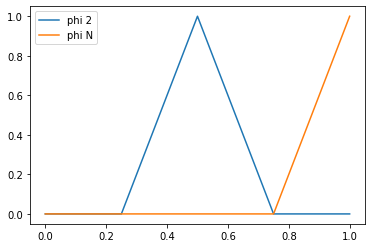

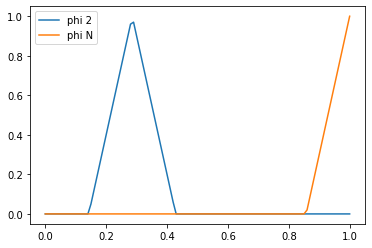

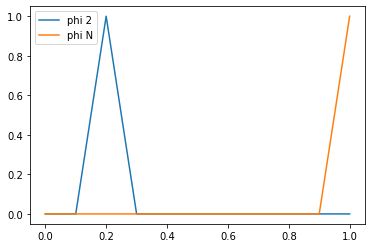

In [28]:
# plot phis

Ns = [4,7,10]

plot_intervals = 100
for N in Ns:
    xn = np.linspace(0,1,N+1)
    x = np.linspace(0,1,plot_intervals+1)
    phi_2 = hatfun_simple(xn,2,x)
    phi_n = hatfun_simple(xn,N,x)

    plt.plot(x,phi_2, label='phi 2')
    plt.plot(x,phi_n, label='phi N')
    plt.legend()
    plt.show()

**b**) Write a Python script ${\texttt { interp1d(f, xn, x)}}$, that computes the linear interpolant $\pi f_k\in V_h$, $k=1,2,3$ of 

* $f_1(x)=x\sin (3\pi x)$
* $f_2(x)=2-10x$
* $f_3(x)=x(1-x)$

by using your function ${\texttt {hatfun}}$. 

Hint: Recall that the interpolant is defined by
$$
\pi f(x) = \sum_{i=0}^{N} f(x_i) \varphi_i(x)
$$
Compute the error in the numerical solution using the $L^2$-norm
$
    \left(\| v \|_{L^2(I)}= \left( \int_I v^2 \right)^{1/2}\right)
$
and present the results in Log-Log plots (error versus $h$) using partitions with $N=2^2,2^3,...,2^6$. Do the errors behave as  
$$
\| f - \pi f \|_{L^2(I)}^2 \leqslant C \sum_{i=0}^{N} h_i^4 \| f'' \|_{L^2(I_i)}^2
$$
for all cases? 
*Hint*: Use the code for the Simpson's formula to compute the $L^2$-norm per interval in the partition.

## Answers

# b)
See code and plots below.

Regarding the errors, we can see from the figures that for the functions $f_1$ and $f_3$, the error is bounded by the given expression. However, for $f_2$, this is not the case. The bounded term is zero (due to the second derivative being zero), while the error is greater than zero.

In [10]:
def interp1d(f, xn, x):
    sum = 0
    for i in range(0, xn.size-1):
        sum += f(xn[i])*hatfun_simple(xn, i, x)
    return sum

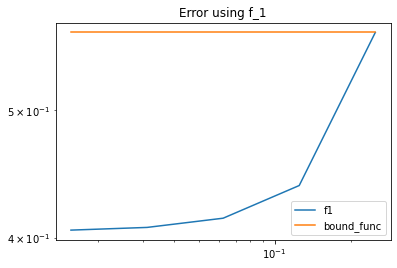

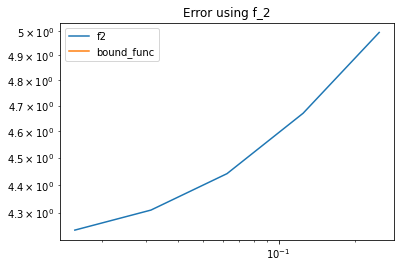

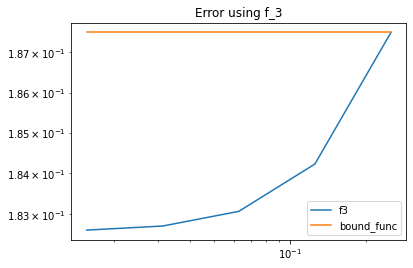

In [29]:
f_1 = lambda x : x * np.sin(3 * np.pi * x)
f_2 = lambda x : 2 - 10 * x
f_3 = lambda x : x * (1-x)

f_1_bis = lambda x : 6 * np.pi * np.cos(3 * np.pi * x) - x*(3*np.pi)**2 * np.sin(3*np.pi*x)
f_2_bis = lambda x : 0
f_3_bis = lambda x : -2

fs = [f_1, f_2, f_3]
f_bisses = [f_1_bis, f_2_bis, f_3_bis]

Ns = [4, 8, 16, 32, 64]
hs = 1/np.array(Ns)
for i in range(0, len(fs)):
    f = fs[i]
    f_bis = f_bisses[i]

    errors = []

    bound_term = 0
    for N, h in zip(Ns, hs):
        xn = np.linspace(0,1, N+1)

        interp_integ = 0
        f_bis_norm_squared = 0
        for j in range(0, N):
            x_p = np.array((xn[j], (xn[j+1]+xn[j])/2, xn[j+1]))
            y_p = (interp1d(f, xn, x_p) - f(x_p))**2
            interp_integ += num_integrate(x_p, y_p, 'simpsons')

            y_p_bis = (f_bis(x_p[0])**2, f_bis(x_p[1])**2, f_bis(x_p[2])**2)
            f_bis_norm_squared += num_integrate(x_p, y_p_bis, 'simpsons')


        l2_norm = np.sqrt(interp_integ)
        bound_term += h**4*f_bis_norm_squared;

        errors.append(l2_norm)

    C = 0.
    for error in errors:
        if bound_term > 0.00000001:
            C = np.max([error/bound_term, C])            

    plt.figure(i)
    plt.title(f'Error using f_{(i+1)}')
    plt.loglog(hs, errors,label=f'f{(i+1)}')
    plt.loglog(hs, np.ones(hs.shape) * C * bound_term, label=f'bound function')
    plt.legend()
    #plt.show()